#load

In [1]:
import numpy as np
import pandas as pd
pd.set_option("max_colwidth", 180)

import json
import glob
from scipy.stats import pearsonr, pointbiserialr

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")

<ipython-input-1-ced9e34f7bda>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def load_data(file_path, indx = True, indx_col = 0):
  '''Parameters:
  file_path: path to your excel or csv file with data,

  indx: boolean - whether there is index column in your file (usually it is the first column) --> *by default it is set to True
  
  indx_col: int - if your file has an index column, specify column number here --> *by default it is equal to 0 (first column)
  '''
  if indx == True and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path)

  elif indx == True and file_path.endswith(".csv"):
    data = pd.read_csv(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".csv"):
    data = pd.read_csv(file_path)
  return data


In [ ]:
import io
from google.colab import files

uploaded = files.upload()

#maps aif

In [3]:
maps1 = glob.glob("/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/schemes_annotation/corpuses/my/*.json")
maps2 = glob.glob("/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/schemes_annotation/corpuses/jn/*.json")
maps3 = glob.glob("/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/schemes_annotation/corpuses/g1/*.json")
maps4 = glob.glob("/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/schemes_annotation/corpuses/r1/*.json")

maps = maps1 + maps2 + maps3 + maps4

In [4]:
len(maps), maps[:3]

(190,
 ['/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/schemes_annotation/corpuses/my/nodeset24388.json',
  '/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/schemes_annotation/corpuses/my/nodeset24390.json',
  '/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/schemes_annotation/corpuses/my/nodeset24391.json'])

In [ ]:
maps

In [9]:
df =  pd.DataFrame(columns = ['conclusion', 'premise', 'map_ID', 'scheme'])
df

,conclusion,premise,map_ID,scheme


In [10]:
sc = ['Default Inference', 'Positive Consequences', 'Negative Consequences', 
      'Fear Appeal', 'Danger Appeal', 
      'Causal Slippery Slope', 'Waste', 'Need For Help']

##extract RA

In [11]:
def conclusionPremiseDict(premises, conclusions):
    pairs = {}
    for i, x in enumerate(conclusions):
        pairs[i] = {'conclusion':x, 'premises':[]}
        id_to = x['fromID']
        for p in premises:
            if p['toID'] == id_to:
                pairs[i]['premises'].append(p)                
    return pairs

def aduPairs(edgePairs, nodesById):
    aduPair = []
    for pair in edgePairs.values():
        for p in pair['premises']:
          aduPair.append([nodesById[pair['conclusion']['toID']]['text'], nodesById[p['fromID']]['text']])    
    return aduPair

def pairs(map, scheme):
    with open(map) as f:
        data = json.loads(f.read())
    nodesById = {}
    for _, node in enumerate(data['nodes']):
        nodesById[node['nodeID']] = node
        
    premises = [x for x in data['edges'] if nodesById[x['fromID']]['type'] == 'I' and nodesById[x['toID']]['text'] == s] # dromID type type":"TA" and to type = L 

    conclusions = [x for x in data['edges'] if nodesById[x['fromID']]['text'] == s and nodesById[x['toID']]['type'] == 'I']
    edgePairs = conclusionPremiseDict(premises, conclusions)
    adus = aduPairs(edgePairs, nodesById)
    return adus, conclusions, premises, nodesById    



for s in sc:
  truePairs = []
  conclusions = []
  premises = []
  nodesById = {}

  truePairs = []
  conclusions = []
  premises = []
  nodesById = {}
  map_number = []
  for i, m in enumerate(maps):
      adus, c, p, n = pairs(m, scheme = s)
      truePairs.extend(adus)
      conclusions.extend(c)
      premises.extend(p)
      nodesById = {**nodesById, **n}

      for num in range(len(adus)):
        map_number.append(maps[i][-10:-5])

  df0 = pd.DataFrame(truePairs)
  print(s)
  df0.columns = ["conclusion", "premise"]
  df0["map_ID"] = map_number     
  df0['scheme'] = s
  df = pd.concat( [df, df0], axis=0, ignore_index=True )

df.shape

Default Inference
Positive Consequences
Negative Consequences
Fear Appeal
Danger Appeal
Causal Slippery Slope
Waste
Need For Help


(1621, 4)

In [12]:
df.sample(4)

,conclusion,premise,map_ID,scheme
832,"Tadeusz Gołębiewski zastawił cały swój majątek, aby ratować 950 miejsc pracy","rząd i kandydat Andrzej Duda nie robią nic, żeby pomóc polskim przedsiębiorcom",24567,Positive Consequences
895,CLINTON wants to reassure USA allies in Japan and South Korea and elsewhere that USA have mutual defense treaties and USA will honor them,it is essential that America 's word be good,24474,Positive Consequences
821,w Europie powinniśmy postawić na współpracę,"to właśnie dlatego w ramach współdziałania i wsparcia wysłaliśmy grupę naszych lekarzy do Włoch po to, żeby wsparli Włochów w bardzo trudnej wtedy dla nich sytuacji walki z kor...",24424,Positive Consequences
83,"Robert Biedroń przeszedł długą drogę, żeby stanąć dzisiaj tutaj i zostać politykiem.",Robert Biedroń jest zwykłym chłopakiem z ulicy Kolejowej w Krośnie,24566,Default Inference


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1621 entries, 0 to 1620
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   conclusion  1621 non-null   object
 1   premise     1621 non-null   object
 2   map_ID      1621 non-null   object
 3   scheme      1621 non-null   object
dtypes: object(4)
memory usage: 50.8+ KB


In [15]:
df.to_excel('/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/schemes_annotation.xlsx')

In [17]:
df.scheme.value_counts()

Default Inference        772
Positive Consequences    340
Negative Consequences    299
Need For Help             81
Danger Appeal             69
Fear Appeal               44
Causal Slippery Slope     12
Waste                      4
Name: scheme, dtype: int64

In [16]:
df.scheme.value_counts(normalize=True).round(3)*100

Default Inference        47.6
Positive Consequences    21.0
Negative Consequences    18.4
Need For Help             5.0
Danger Appeal             4.3
Fear Appeal               2.7
Causal Slippery Slope     0.7
Waste                     0.2
Name: scheme, dtype: float64

##plots stats

In [18]:
arg_melt = df.copy()

In [19]:
arg_melt.groupby('scheme', as_index=False).size()

,scheme,size
0,Causal Slippery Slope,12
1,Danger Appeal,69
2,Default Inference,772
3,Fear Appeal,44
4,Need For Help,81
5,Negative Consequences,299
6,Positive Consequences,340
7,Waste,4


In [27]:
arg_melt2 = arg_melt.groupby('scheme', as_index=False).size()
arg_melt2['size'] = (arg_melt2['size'] / df.shape[0]).round(3)*100
arg_melt2 = arg_melt2.sort_values(by = 'size')
arg_melt2

,scheme,size
7,Waste,0.2
0,Causal Slippery Slope,0.7
3,Fear Appeal,2.7
1,Danger Appeal,4.3
4,Need For Help,5.0
5,Negative Consequences,18.4
6,Positive Consequences,21.0
2,Default Inference,47.6


In [21]:
sns.set(font_scale=1.3, style='whitegrid')

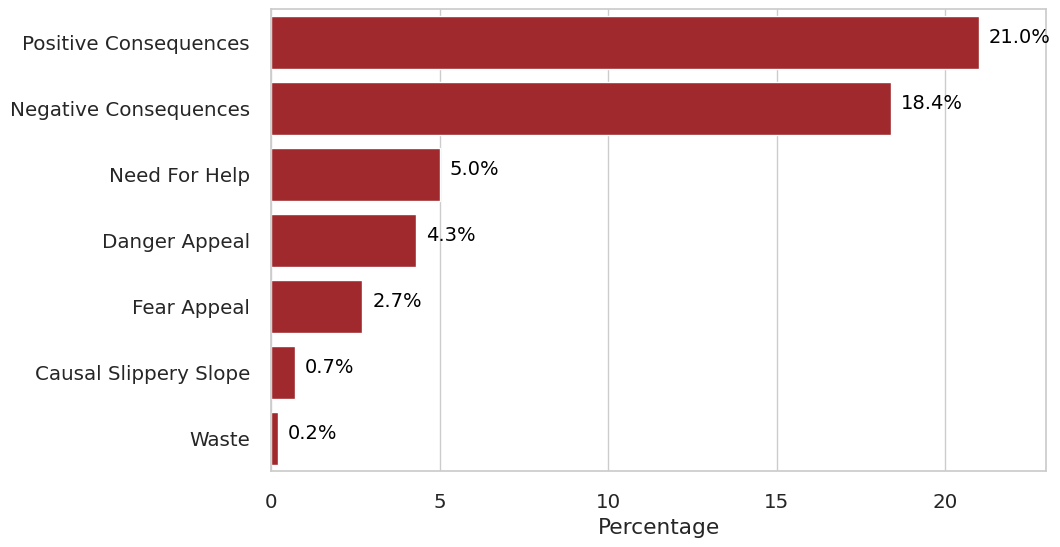

In [30]:
plt.figure(figsize=(10, 6))
ff = sns.barplot(data = arg_melt2.iloc[:-1].sort_values(by = 'size', ascending=False), y = 'scheme', x = 'size', 
            palette = ['#B31519', '#B31519', '#B31519', '#B31519', '#B31519', '#B31519', '#B31519', '#ACACAC'])

y = arg_melt2.iloc[:-1].sort_values(by = 'size', ascending=False)["size"].round(3).values
for i, v in enumerate(y):
    ff.text(v+0.3, i, f"{v:,}%", color='black', size=14)#fontweight='bold', 

plt.ylabel("")
plt.xlim(0, 23)
plt.xlabel("Percentage")
plt.show()

In [35]:
arg_pat = arg_melt2[arg_melt2.scheme!='Default Inference']['size'].sum()
arg_def = arg_melt2[arg_melt2.scheme =='Default Inference']['size'].iloc[0]

arg_pat.round(), arg_def.round()

(52.0, 48.0)

In [36]:
arg_melt3 = pd.DataFrame({'scheme':['Default Inference', 'Pathotic Arguments'], 'size': [48, 52]})
arg_melt3 = arg_melt3.sort_values(by = 'size', ascending=False)
arg_melt3.scheme = arg_melt3.scheme.str.replace("Default Inference", "Non Pathotic Arguments")
arg_melt3

,scheme,size
1,Pathotic Arguments,52
0,Non Pathotic Arguments,48


Text(0.5, 0, 'Percentage')

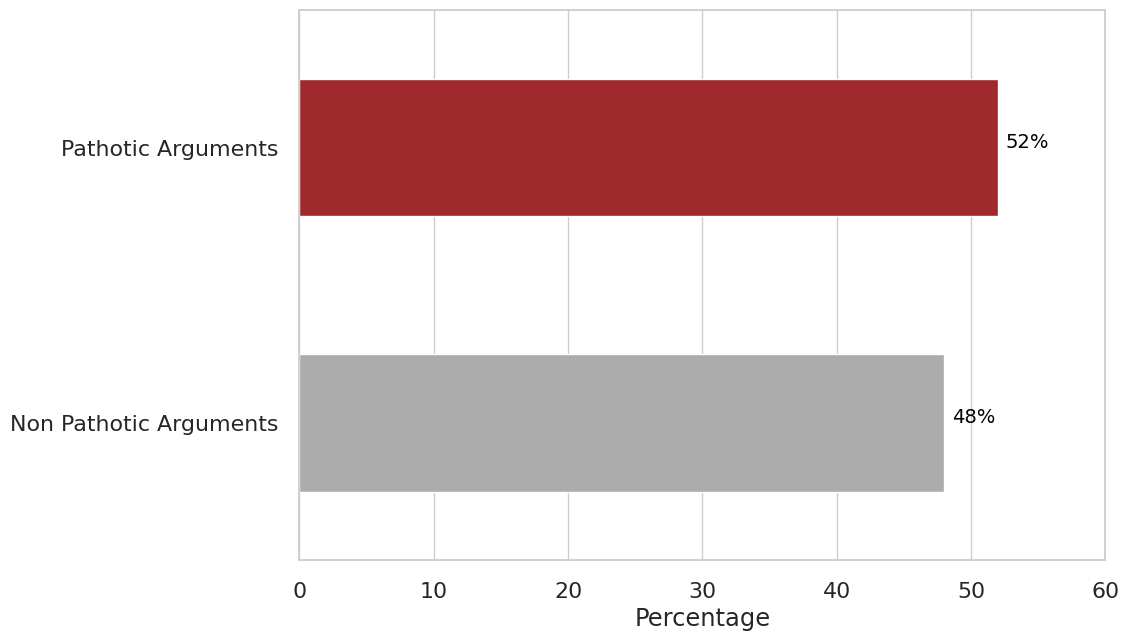

In [39]:
sns.set(font_scale = 1.45, style= 'whitegrid')
ff = sns.barplot(data = arg_melt3, y = 'scheme', x = 'size', 
            palette = ['#B31519','#ACACAC'], hue = 'scheme',  
            width = 0.5, dodge=False)

y = arg_melt3["size"].round(3).values
for i, v in enumerate(y):
    ff.text(v+0.6, i, f"{v:,}%", color='black', size=14)#fontweight='bold', 
plt.legend([],[], frameon=False)
plt.ylabel("")
plt.xlim(0, 60)
plt.xlabel("Percentage")

#US data

In [40]:
merged = load_data('/content/drive/MyDrive/Colab Notebooks/debates/us2016itc/itc_US_processed_debate_arg_only.xlsx')
merged.shape

(707, 116)

In [41]:
merged = merged[merged.debate.isin(['G1', 'R1'])]
merged.shape

(482, 116)

In [42]:
# divide corpus into separate debate corpora
rdeb = merged[merged.debate == 'R1']
gdeb = merged[merged.debate == 'G1']

rdeb.shape, gdeb.shape

((314, 116), (168, 116))

In [ ]:
gdeb.iloc[:2, :20].head(2)

In [137]:
# calculate percentage of pos, neg and neutral sentiment for each politician claim - r1  recognized_emotion  recognised_sentiment

rdeb_grpd = pd.DataFrame(rdeb.groupby("debate_claim", as_index=True)['recognized_emotion'].value_counts(normalize = True).round(2) * 100)
rdeb_grpd.columns = ['_'.join(col) for col in rdeb_grpd.columns]
rdeb_grpd = rdeb_grpd.reset_index()
rdeb_grpd.columns = ['debate_claim', 'pathotic_response', 'percentage']
rdeb_grpd.iloc[:5]

,debate_claim,pathotic_response,percentage
0,"71 % of federal spending right now is on entitlements , and debt service , 71 %",surprise,81.0
1,"71 % of federal spending right now is on entitlements , and debt service , 71 %",fear,6.0
2,"71 % of federal spending right now is on entitlements , and debt service , 71 %",joy,6.0
3,"71 % of federal spending right now is on entitlements , and debt service , 71 %",sadness,6.0
4,as governor of the state of florida i created the first statewide voucher program in the country,surprise,80.0


In [138]:
# calculate percentage of pos, neg and neutral sentiment for each politician claim - g1

gdeb_grpd = pd.DataFrame(gdeb.groupby("debate_claim", as_index=True)['recognized_emotion'].value_counts(normalize = True).round(2) * 100)
gdeb_grpd.columns = ['_'.join(col) for col in gdeb_grpd.columns]
gdeb_grpd = gdeb_grpd.reset_index()
gdeb_grpd.columns = ['debate_claim', 'pathotic_response', 'percentage']
gdeb_grpd.iloc[:5]

,debate_claim,pathotic_response,percentage
0,b-52s are old enough that one's father or grandfather could be flying them,surprise,60.0
1,b-52s are old enough that one's father or grandfather could be flying them,joy,20.0
2,b-52s are old enough that one's father or grandfather could be flying them,anger,10.0
3,b-52s are old enough that one's father or grandfather could be flying them,sadness,10.0
4,"clinton and others , politicians , should have been doing this for years , not right now",surprise,70.0


In [139]:
# add the columns with calculated proportions to the original data 

rdeb_plot = rdeb.merge(rdeb_grpd, on = 'debate_claim', how = 'left')
print(rdeb_plot.shape)
rdeb_plot.drop_duplicates(['debate_claim','pathotic_response'], inplace=True)
print(rdeb_plot.shape)

rdeb_plot.reset_index(inplace = True, drop = True)

(1014, 118)
(87, 118)


In [140]:
gdeb_plot = gdeb.merge(gdeb_grpd, on = 'debate_claim', how = 'left')
print(gdeb_plot.shape)
gdeb_plot.drop_duplicates(['debate_claim','pathotic_response'], inplace=True)
print(gdeb_plot.shape)

gdeb_plot.reset_index(inplace = True, drop = True)

(476, 118)
(45, 118)


In [141]:
gdeb_plot[['debate_claim','pathotic_response', 'percentage']].iloc[:5]

,debate_claim,pathotic_response,percentage
0,"that starts with raising the national minimum wage and also guarantee , finally , equal pay for women 's work",surprise,85.0
1,"that starts with raising the national minimum wage and also guarantee , finally , equal pay for women 's work",anger,10.0
2,"that starts with raising the national minimum wage and also guarantee , finally , equal pay for women 's work",sadness,5.0
3,so ford is leaving,surprise,90.0
4,so ford is leaving,joy,10.0


##corr emo-elicit lang

In [ ]:
eliciting_emo = ['conclusion_joy',
 'conclusion_anger',
 'conclusion_sadness',
 'conclusion_fear',
 'conclusion_disgust',
 'conclusion_surprise',
 'conclusion_trust', 'conclusion_anticipation', 
 'premises_joy',
 'premises_anger',
 'premises_sadness',
 'premises_fear',
 'premises_disgust',
 'premises_surprise',
 'premises_trust',
 'premises_anticipation',
 'full_argument_joy',
 'full_argument_anger',
 'full_argument_sadness',
 'full_argument_fear',
 'full_argument_disgust',
 'full_argument_trust', 'full_argument_surprise', 'full_argument_anticipation']

In [ ]:
# apply logarithmic transformation to the proportions of eliciting emotions

for c in eliciting_emo:
  rdeb_plot[c] = rdeb_plot[c].apply(lambda x: np.log(x+1))
  gdeb_plot[c] = gdeb_plot[c].apply(lambda x: np.log(x+1))

In [ ]:
# apply logarithmic transformation to the proportions of expressed emotions

rdeb_plot['percentage'] = rdeb_plot['percentage'].apply(lambda x: np.log(x+1))
gdeb_plot['percentage'] = gdeb_plot['percentage'].apply(lambda x: np.log(x+1))

In [ ]:
# define a set of expressed emotions / sentiment

emo = ['surprise', 'fear', 'joy', 'anger', 'sadness', 'disgust'] 
# ['surprise', 'fear', 'joy', 'anger', 'sadness', 'disgust']    ['Positive', "Negative"]

# define a debate data for calculation of correlation
df = gdeb_plot.copy()  

claims = df.debate_claim.unique() 
df = df.dropna(axis=0)

In [ ]:
df.shape

(26, 118)

In [ ]:
from scipy.stats import pearsonr, pointbiserialr

In [ ]:
one = []
second = []
corcof = []
pvals = []


for ex in emo:  
  for el in eliciting_emo:    
    epx_val = []
    elic_val = []

    # for the claim c, expressed category ex and eliciting category el retrieve the values for eliciting and expressed emotions
    for c in claims:
      emotions = df[df.debate_claim == c]['pathotic_response'].unique()
      len_eliciting = len(df[(df.debate_claim == c) & (df.pathotic_response == ex) ])
      if len_eliciting > 0:
        eliciting = df[(df.debate_claim == c) & (df.pathotic_response == ex) ][el].iloc[0]
        elic_val.append(eliciting)
      else:
        eliciting = 0


      if ((ex in emotions) and (len_eliciting > 0)):
        express_val = df[ (df.debate_claim == c) & (df.pathotic_response == ex) ]['percentage'].iloc[0]
        epx_val.append(express_val)
      elif ((ex not in emotions) and (len_eliciting > 0)):
        epx_val.append(0)
      else:
        pass
    # if for a given combination of el and ex there is more than 8 cases then calculate correlation (in order to be somehow reliable, not to take just 2 or 3 numbers )
    if len(elic_val) > 8 and len(epx_val):

      coef2, pval = pearsonr(elic_val, epx_val)
      print(ex,  ' -- ', el)
      if pval < 0.05:
        print(epx_val, elic_val)
      print(round(coef2, 2), round(pval, 3), "\n")
      if coef2 != np.nan:
        corcof.append(round(coef2, 2))
        pvals.append(round(pval, 3))
        one.append(ex)
        second.append(el)



In [ ]:
# pearson r correlation - general df

df_cor4 = pd.DataFrame({"first_emotion": one, 
                       "second_emotion": second, 
                       "cor": corcof, 
                       "p_value":pvals})

df_cor4.head(2)

,first_emotion,second_emotion,cor,p_value
0,surprise,conclusion_joy,-0.1,0.803
1,surprise,conclusion_anger,-0.6,0.086


In [ ]:
df_cor4[df_cor4.p_value < 0.05] # R1 emotions w log transform

In [ ]:
df_cor4[df_cor4.p_value < 0.05] # G1 emotions w log transform

##Arg scheme match

In [48]:
df_schems = load_data('/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/schemes_annotation.xlsx')
df_schems.shape

(1621, 4)

In [65]:
arg = df_schems.copy()

In [68]:
arg.sample()

,conclusion,premise,map_ID,scheme
390,TRUMP was one of the people who rooted for the housing crisis,housing did collapse,24694,Default Inference


In [66]:
arg.reset_index(drop=True, inplace=True)

In [69]:
arg.scheme.value_counts(normalize=True)

Default Inference        0.476249
Positive Consequences    0.209747
Negative Consequences    0.184454
Need For Help            0.049969
Danger Appeal            0.042566
Fear Appeal              0.027144
Causal Slippery Slope    0.007403
Waste                    0.002468
Name: scheme, dtype: float64

In [70]:
df_schems[df_schems.scheme == 'Fear Appeal'].shape

(44, 4)

In [72]:
rdeb_grpd.shape

(72, 3)

In [73]:
rdeb_grpd.iloc[:2]

,debate_claim,pathotic_response,percentage
0,"71 % of federal spending right now is on entitlements , and debt service , 71 %",Negative,50.0
1,"71 % of federal spending right now is on entitlements , and debt service , 71 %",Neutral,50.0


In [74]:
gdeb_grpd.iloc[:2]

,debate_claim,pathotic_response,percentage
0,b-52s are old enough that one's father or grandfather could be flying them,Negative,50.0
1,b-52s are old enough that one's father or grandfather could be flying them,Neutral,30.0


In [75]:
rdeb_grpd['percentage'].iloc[:2]

0    50.0
1    50.0
Name: percentage, dtype: float64

In [142]:
rdeb_grpd['percentage'] = rdeb_grpd['percentage'].apply(lambda x: np.log(x+1))
gdeb_grpd['percentage'] = gdeb_grpd['percentage'].apply(lambda x: np.log(x+1))


In [143]:
gdeb_grpd = gdeb_grpd.reset_index(drop=True)
rdeb_grpd = rdeb_grpd.reset_index(drop=True)

In [144]:
rdeb_grpd['percentage'].iloc[:2]

0    4.406719
1    1.945910
Name: percentage, dtype: float64

In [156]:
# take only those annotated arg. schemes that are in a particular debate

# change corpus df - gdeb_grpd / rdeb_grpd
dd = gdeb_grpd  # gdeb_grpd / rdeb_grpd

id_arg = []
id_deb = []
for i in arg.index:
  for i2 in dd.index:
    if (arg.loc[i, 'conclusion'].strip().lower() in dd.loc[i2, 'debate_claim'].strip().lower()) or (arg.loc[i, 'premise'].strip().lower() in dd.loc[i2, 'debate_claim'].strip().lower()):
      id_arg.append(i)
      id_deb.append(i2)

len(id_arg), len(id_deb), id_arg[:3]

(58, 58, [335, 335, 335])

In [172]:
# merge itc corpus with data on annotated arg. schemes

argmatched = arg.loc[id_arg]
argmatched.reset_index(drop=True, inplace=True)

debmatched = dd.loc[id_deb]
debmatched.reset_index(drop=True, inplace=True)

dfmatched = pd.concat([argmatched, debmatched], axis = 1)
dfmatched.drop_duplicates(inplace=True)
dfmatched.shape

(58, 7)

In [ ]:
dfmatched.sample(2)

In [173]:
dum_sch = pd.get_dummies(dfmatched['scheme'], prefix = 'scheme_name')
dum_sch.describe()

,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Negative Consequences,scheme_name_Positive Consequences
count,58.000000,58.000000,58.000000,58.000000
mean,0.120690,0.413793,0.310345,0.155172
std,0.328611,0.496814,0.466675,0.365231
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [174]:
schems = dum_sch.columns
schems

Index(['scheme_name_Danger Appeal', 'scheme_name_Default Inference',
       'scheme_name_Negative Consequences',
       'scheme_name_Positive Consequences'],
      dtype='object')

In [175]:
dfmatched = pd.concat([dfmatched, dum_sch], axis = 1)
print(dfmatched.shape)
dfmatched.sample()

(58, 11)


,conclusion,premise,map_ID,scheme,debate_claim,pathotic_response,percentage,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Negative Consequences,scheme_name_Positive Consequences
32,"That starts with raising the national minimum wage and also guarantee , finally , equal pay for women 's work",We also have to make the economy fairer,24524,Positive Consequences,"that starts with raising the national minimum wage and also guarantee , finally , equal pay for women 's work",sadness,1.791759,0,0,0,1


In [176]:
dfmatched[schems].describe()

,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Negative Consequences,scheme_name_Positive Consequences
count,58.000000,58.000000,58.000000,58.000000
mean,0.120690,0.413793,0.310345,0.155172
std,0.328611,0.496814,0.466675,0.365231
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


###Corr biserial

In [177]:
schems = dum_sch.columns
schems

Index(['scheme_name_Danger Appeal', 'scheme_name_Default Inference',
       'scheme_name_Negative Consequences',
       'scheme_name_Positive Consequences'],
      dtype='object')

In [178]:
# mark 1 is scheme is present, 0 otherwise

for s in schems:
  dfmatched[s] = np.where(dfmatched[s] > 0, 1, 0)

dfmatched[schems].head()

,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Negative Consequences,scheme_name_Positive Consequences
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [179]:
dfmatched[schems].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   scheme_name_Danger Appeal          58 non-null     int64
 1   scheme_name_Default Inference      58 non-null     int64
 2   scheme_name_Negative Consequences  58 non-null     int64
 3   scheme_name_Positive Consequences  58 non-null     int64
dtypes: int64(4)
memory usage: 2.3 KB


In [167]:
dfmatched.pathotic_response.unique()

array(['surprise', 'joy', 'anger', 'sadness', 'disgust', 'fear'],
      dtype=object)

In [ ]:
dfmatched[ (dfmatched['scheme_name_Negative Consequences'] == 1) ]

In [ ]:
#dfmatched[ (dfmatched['scheme_name_Negative Consequences'] == 1) & (dfmatched['pathotic_response'] == 'fear')]

dfmatched[ (dfmatched['pathotic_response'] == 'fear') ]

In [114]:
from scipy.stats import pointbiserialr

####**Emotions**

In [180]:
coeffs_all = []
p_val_all = []
scheme_all = []
emo_all = []

# for scheme s and emotion e retrieve values and calculate correlation
for s in schems:
  print(s)  
  for e in dfmatched.pathotic_response.unique():
    print(e)
    corr_df = dfmatched[dfmatched.pathotic_response == e]
    sm_response_sentiment = corr_df['percentage'].apply(float).values
    binary_scheme = corr_df[s].apply(int).values
    if len(sm_response_sentiment) > 2:
      scheme_all.append(s)
      emo_all.append(e)
      coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
      coeffs_all.append(round(coefbi, 2))
      p_val_all.append(round(bi_p, 3))

    if bi_p <= 0.05:
      print(f'\t {s} - {e} - coeff= {round(coefbi, 2)}:  p= {round(bi_p, 3)}\t n samples: {len(sm_response_sentiment)} ')
      print(len(corr_df))

scheme_name_Danger Appeal
surprise
anger
sadness
joy
fear
scheme_name_Default Inference
surprise
anger
sadness
	 scheme_name_Default Inference - sadness - coeff= 0.88:  p= 0.047	 n samples: 5 
5
joy
fear
scheme_name_Negative Consequences
surprise
anger
sadness
joy
fear
scheme_name_Positive Consequences
surprise
anger
	 scheme_name_Positive Consequences - anger - coeff= -0.61:  p= 0.01	 n samples: 17 
17
sadness
joy
fear


/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [155]:
# R1 up

df_cor_bi_emo = pd.DataFrame({"scheme": scheme_all, 'emotion': emo_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # new

,scheme,emotion,cor,p_value
9,scheme_name_Negative Consequences,fear,0.96,0.011


In [181]:
# G1 up

df_cor_bi_emo = pd.DataFrame({"scheme": scheme_all, 'emotion': emo_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05]# new

,scheme,emotion,cor,p_value
6,scheme_name_Default Inference,sadness,0.88,0.047
13,scheme_name_Positive Consequences,anger,-0.61,0.010


####**Sentiment**

In [115]:
dfmatched.sample()

,conclusion,premise,map_ID,scheme,debate_claim,pathotic_response,percentage,scheme_name_Default Inference,scheme_name_Negative Consequences,scheme_name_Positive Consequences
7,BUSH knows how to do this,as governor of the state of Florida I created the first statewide voucher program in the country,24658,Default Inference,as governor of the state of florida i created the first statewide voucher program in the country,Negative,3.713572,1,0,0


In [ ]:
dfmatched[dfmatched.duplicated(['conclusion', 'premise', 'pathotic_response'])]

In [126]:
dfmatched = dfmatched.drop_duplicates(['conclusion', 'premise', 'pathotic_response'])

In [127]:
dfmatched.shape

(74, 10)

In [128]:
corr_pos = dfmatched[dfmatched.pathotic_response == 'Positive']
corr_pos.shape

(18, 10)

In [129]:
corr_neg = dfmatched[dfmatched.pathotic_response == 'Negative']
corr_neg.shape

(27, 10)

In [98]:
from scipy.stats import pearsonr, pointbiserialr

In [130]:
coeffs_all = []
p_val_all = []
scheme_all = []

# for scheme s and positive sentiment retrieve values and calculate correlation
for s in schems:
  print(s)
  scheme_all.append(s)
  sm_response_sentiment = corr_pos['percentage'].apply(float).values
  binary_scheme = corr_pos[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 3))

  if bi_p <= 0.05:
    print(f'\t {s} - coeff: {coefbi}:  {round(bi_p, 3)}')

scheme_name_Default Inference
scheme_name_Negative Consequences
scheme_name_Positive Consequences


In [131]:
# positive expressed sentiment R1 log transform

df_cor_bi_pos = pd.DataFrame({"scheme": scheme_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_pos # one scheme_name_Fear Appeal  - expressed pos sentiment # new

,scheme,cor,p_value
0,scheme_name_Default Inference,0.12,0.636
1,scheme_name_Negative Consequences,0.12,0.637
2,scheme_name_Positive Consequences,-0.23,0.354


In [101]:
# positive expressed sentiment G1 after log transform

df_cor_bi_pos = pd.DataFrame({"scheme": scheme_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_pos # none # new

,scheme,cor,p_value
0,scheme_name_Danger Appeal,0.38,0.286
1,scheme_name_Default Inference,-0.25,0.486
2,scheme_name_Negative Consequences,0.10,0.779
3,scheme_name_Positive Consequences,-0.25,0.486


In [132]:
coeffs_all = []
p_val_all = []
scheme_all = []

# for scheme s and negative sentiment retrieve values and calculate correlation
for s in schems:
  print(s)
  scheme_all.append(s)
  sm_response_sentiment = corr_neg['percentage'].apply(float).values
  binary_scheme = corr_neg[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 3))

  if bi_p <= 0.05:
    print(f'\t {s} - coeff: {coefbi}:  {round(bi_p, 3)}')

scheme_name_Default Inference
scheme_name_Negative Consequences
scheme_name_Positive Consequences


In [133]:
# negative expressed sentiment R1

df_cor_bi_neg = pd.DataFrame({"scheme": scheme_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_neg # none

,scheme,cor,p_value
0,scheme_name_Default Inference,0.23,0.244
1,scheme_name_Negative Consequences,-0.23,0.246
2,scheme_name_Positive Consequences,-0.11,0.572


In [103]:
# negative expressed sentiment G1

df_cor_bi_neg = pd.DataFrame({"scheme": scheme_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_neg # none - one approaches scheme_name_Negative Consequences p = 0.087

,scheme,cor,p_value
0,scheme_name_Danger Appeal,-0.23,0.318
1,scheme_name_Default Inference,-0.29,0.207
2,scheme_name_Negative Consequences,0.38,0.092
3,scheme_name_Positive Consequences,0.09,0.700


####EmoSaturation

In [104]:
gdeb_plot[['debate_claim','pathotic_response', 'percentage']].iloc[:5]

,debate_claim,pathotic_response,percentage
0,"that starts with raising the national minimum wage and also guarantee , finally , equal pay for women 's work",Negative,65.0
1,"that starts with raising the national minimum wage and also guarantee , finally , equal pay for women 's work",Neutral,35.0
2,so ford is leaving,Neutral,70.0
3,so ford is leaving,Negative,30.0
4,"clinton and others , politicians , should have been doing this for years , not right now",Negative,60.0


In [105]:
# redit
def EmoSaturationDf2(dataframe, text_col, emo_name_col = 'pathotic_response', emo_percent_col = 'percentage'):
  df = dataframe.copy()
  full_cols = ['full_argument_joy','full_argument_anger','full_argument_sadness','full_argument_fear','full_argument_disgust',]
  texts = df[text_col].unique()
  df['EmotionalSaturationSocialMedia'] = np.nan

  for t in texts:
    ids = df[ df[text_col] == t].index
    elic_emotions = df.loc[ids, full_cols].applymap(lambda x : x if x > 0 else np.nan).mean(axis=1).values
    df.loc[ids, 'EmotionalSaturationDebate'] = elic_emotions
    
    emotions = np.nansum(df[ (df[text_col] == t) & (df[emo_name_col] != 'Neutral') ][emo_percent_col].values)
    df.loc[ids, 'EmotionalSaturationSocialMedia'] = emotions

  return df

In [ ]:
rdeb_plot[full_cols].iloc[:5]

In [ ]:
df = EmoSaturationDf2(rdeb_plot, text_col = 'debate_claim')
df.iloc[:5, -3:]

,percentage,EmotionalSaturationSocialMedia,EmotionalSaturationDebate
0,50.0,50.0,NaN
1,42.0,50.0,NaN
2,8.0,50.0,NaN
3,47.0,53.0,0.30333
4,41.0,53.0,0.30333


In [ ]:
df = df.drop_duplicates('debate_claim')
df.shape

(28, 120)

In [ ]:
#dfg = df.copy()
#dfr = df.copy()

df = pd.concat( [dfg[['EmotionalSaturationSocialMedia', 'EmotionalSaturationDebate']], 
                 dfr[['EmotionalSaturationSocialMedia', 'EmotionalSaturationDebate']]], 
               axis = 0, ignore_index = True )
df.shape

(44, 2)

In [ ]:
df.iloc[::5, -3:]

,EmotionalSaturationSocialMedia,EmotionalSaturationDebate
0,65.0,0.052400
5,80.0,0.097800
10,100.0,0.167850
15,70.0,NaN
20,67.0,0.073000
25,75.0,0.147566
30,40.0,0.096000
35,30.0,0.067972
40,50.0,0.109383


In [ ]:
rc, pc = pearsonr(df.EmotionalSaturationSocialMedia.fillna(0).values, df.EmotionalSaturationDebate.fillna(0).values)
round(rc, 2), round(pc, 3) # g1 + r1

(0.16, 0.305)

In [ ]:
rc, pc = pearsonr(dfg.EmotionalSaturationSocialMedia.fillna(0).values, dfg.EmotionalSaturationDebate.fillna(0).values)
round(rc, 2), round(pc, 3) # g1

(-0.4, 0.129)

In [ ]:
rc, pc = pearsonr(dfr.EmotionalSaturationSocialMedia.fillna(0).values, dfr.EmotionalSaturationDebate.fillna(0).values)
round(rc, 2), round(pc, 3) # r1

(0.42, 0.027)

#PL data

In [308]:
# debata_2020_June_all_DATA_up23
# debata_2020_May_all_DATA_up23

d_path = "/content/drive/MyDrive/Colab Notebooks/debates/debata_2020_June_all_DATA_up23.xlsx"

In [309]:
df = load_data(d_path)
df["Time"] = pd.to_datetime(df.start)
df.shape

(150, 38)

In [310]:
# tweet_Czerwiec_expressed_sentiment
# tweet_May_expressed_sentiment

social_media = load_data("/content/drive/MyDrive/Colab Notebooks/debates/validation_samples/tweet_Czerwiec_expressed_sentiment.xlsx")
social_media.sort_values(by = 'Data', inplace=True)
social_media["Time"] = social_media["Data"].dt.time.apply(str)
social_media.shape

(35360, 12)

In [311]:
social_media.sample(3)

,Data,Tekst,clean_Tekst,predicted_emotion_PaREMO,predicted_emotion_label_PaREMO,sentiment_PaRes,sentiment_label_PaRes,predicted_emotion_XLM_tuned,predicted_emotion_label_XLM_tuned,predicted_emotion_PaREMO_2,predicted_emotion_label_PaREMO_2,Time
65472,2020-06-17 21:39:50,"@mhorala @Gnoj2013 Jacek, nie podawaj mi tego gnoja.","jacek, nie podawaj mi tego gnoja.",1,anger,0,neg,2,disgust,2,disgust,21:39:50
72476,2020-06-17 21:28:51,Miałam wrażenie jakby Biedroń miał łzy w oczach. #debataprezydencka,miałam wrażenie jakby biedroń miał łzy w oczach.,5,sadness,0,neg,3,fear,6,surprise,21:28:51
34676,2020-06-17 22:24:04,@PiotrGlinski Bo chciał powiedzieć Kaczyński.,bo chciał powiedzieć kaczyński.,1,anger,1,neu,6,surprise,0,neutral,22:24:04


##join data

In [186]:
def process_reactions(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  time shift = -1min;
  
  dataframe_social_media: data with social media reactions (comments), 

  dataframe_debate: data with debate arguments, 
  
  analysis_type: 'sentiment' or 'emotions', 

  """
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)

  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["predicted_emotion_label_PaREMO"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'emotion', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'emotion'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)

    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

  return df_plot_join

In [312]:
df_corr_pl_processed = process_reactions(dataframe_social_media = social_media, 
                                        dataframe_debate = df, 
                                        analysis_type = 'sentiment') # sentiment  emotion

# take data only from the time of the live debate
may_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-05-06 20:34:00') & (df_corr_pl_processed.Data <= '2020-05-06 21:42:00') ]
june_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-06-17 21:03:00') & (df_corr_pl_processed.Data <= '2020-06-17 22:18:00') ]


df_corr_pl_processed = june_data 
df_corr_pl_processed = df_corr_pl_processed.reset_index(drop=True)
print(df_corr_pl_processed.shape, '\n')
df_corr_pl_processed.head(3)

(228, 26) 



,Data,sentiment_label_PaRes,mean,Time,question number,conclusion_joy,conclusion_anger,conclusion_sadness,conclusion_fear,conclusion_disgust,...,premise_disgust,premise_valence,premise_arousal,full_argument_joy,full_argument_anger,full_argument_sadness,full_argument_fear,full_argument_disgust,full_argument_valence,full_argument_arousal
0,2020-06-17 21:03:00,neg,65.142857,21:03:00,1.0,0.275525,0.03937,0.0,0.089045,0.0,...,0.045313,0.580707,0.413097,0.22865,0.032057,0.0,0.066417,0.03776,0.580603,0.377823
1,2020-06-17 21:03:00,neu,21.714286,21:03:00,1.0,0.275525,0.03937,0.0,0.089045,0.0,...,0.045313,0.580707,0.413097,0.22865,0.032057,0.0,0.066417,0.03776,0.580603,0.377823
2,2020-06-17 21:03:00,pos,13.142857,21:03:00,1.0,0.275525,0.03937,0.0,0.089045,0.0,...,0.045313,0.580707,0.413097,0.22865,0.032057,0.0,0.066417,0.03776,0.580603,0.377823


In [188]:
eliciting_emo = ['conclusion_joy', 'conclusion_anger',
       'conclusion_sadness', 'conclusion_fear', 'conclusion_disgust',
       'premise_joy','premise_anger', 'premise_sadness', 'premise_fear', 'premise_disgust',
       'full_argument_joy',
       'full_argument_anger', 'full_argument_sadness', 'full_argument_fear',
       'full_argument_disgust']

In [313]:
# optional:  apply logarithmic transformation to the calculated proportions of emotions

df_corr_pl_processed['mean'] = df_corr_pl_processed['mean'].apply(lambda x: np.log(x+1))

df_corr_pl_processed[eliciting_emo] = df_corr_pl_processed[eliciting_emo].applymap(lambda x: np.log(x+1))

In [191]:
df_corr_pl_processed[(df_corr_pl_processed[eliciting_emo].any(axis=1))].shape

(168, 26)

###calculate coefficients

**Emotion eliciting**

In [192]:
from scipy.stats import pearsonr, spearmanr

In [ ]:
one = []
second = []
corcof = []
pvals = []

for e_exp in emo:
  df_cor = df_corr_pl_processed[ (df_corr_pl_processed.emotion == e_exp) & \
                                (df_corr_pl_processed[eliciting_emo].any(axis=1)) ]
  for e_el in eliciting_emo:
    sample_exp = df_cor['mean'].values
    sample_elicit = df_cor[e_el].values
    print(f"Exp: {e_exp} - El: {e_el} ")
    coef, pval = pearsonr(sample_exp, sample_elicit)
    coef_spear, pval_spear = spearmanr(sample_exp, sample_elicit)
    print('Spearman ', round(coef_spear, 2), round(pval_spear, 3))
    print('Pearson ', round(coef, 2), round(pval, 3))
    if pval <= 0.05:
      print("\n \t **** H0 could be rejected !! \n")
    print("\n")
    one.append(e_exp)
    second.append(e_el)
    corcof.append(round(coef, 3))
    pvals.append(round(pval, 3))


In [ ]:
df_res = pd.DataFrame({"first_emotion": second, 
                       "second_emotion": one, 
                       "cor": corcof, 
                       "p_value":pvals})
df_res.head(2)

,first_emotion,second_emotion,cor,p_value
0,conclusion_joy,anger,-0.357,0.007
1,conclusion_anger,anger,0.129,0.345


In [ ]:
df_res[df_res.p_value <= 0.05].sort_values(by = 'first_emotion') # may

In [ ]:
df_res[df_res.p_value <= 0.05].sort_values(by = 'first_emotion')  # june

##argument scheme - exp emo

In [314]:
df = df.reset_index(drop=True)
df.sample()

,conclusion,premise,conclusion_lemmatized,premise_lemmatized,full_argument,full_argument_lemmatized,speaker,text,text_L,question,...,premise_valence,premise_arousal,full_argument_joy,full_argument_anger,full_argument_sadness,full_argument_fear,full_argument_disgust,full_argument_valence,full_argument_arousal,Time
37,zdaniem Władysława Kosiniaka-Kamysza dzisiaj nie jest problemem czy lekcje religii odbywają się w szkołach,w większości krajów europejskich lekcje religii odbywają sie w szkołach,zdanie władysław kosiniak kamysz problem lekcja religia odbywać szkoła,większość kraj europejski lekcja religia odbywać szkoła,zdaniem Władysława Kosiniaka-Kamysza dzisiaj nie jest problemem czy lekcje religii odbywają się w szkołach w większości krajów europejskich lekcje religii odbywają sie w szkołach,zdanie władysław kosiniak kamysz problem lekcja religia odbywać szkoła większość kraj europejski lekcja religia odbywać szkoła,Władysław Kosiniak-Kamysz,"Szanowni państwo jako Prezydent Rzeczypospolitej, będę stał na straży wartości takich jak: prawda, sprawiedliwość, dobro i piękno. Będę dbał o wolność religijną i o swobody rel...",Władysław Kosiniak-Kamysz : Moim zdaniem dzisiaj nie jest problemem czy lekcje religii odbywają się w szkołach,"To będzie pytanie ze świata wartości. Wartości bardzo bliskich olbrzymiej większości Polaków. Czas pierwszych Komunii Świętych, a zatem czy jest Pan za umożliwieniem dzieciom p...",...,0.56922,0.33569,0.2177,0.0,0.0539,0.06091,0.0,0.53248,0.34023,2023-03-29 21:24:00


In [315]:
id_arg = []
id_deb = []

for i in arg.index:
  for i2 in df.index:    
    if (arg.loc[i, 'conclusion'].strip().lower() in df.loc[i2, 'full_argument'].strip().lower()) and (arg.loc[i, 'premise'].strip().lower() in df.loc[i2, 'full_argument'].strip().lower()):
      print(arg.loc[i, 'conclusion'].strip().lower())
      print(arg.loc[i, 'premise'].strip().lower())
      print(df.loc[i2, 'full_argument'].strip().lower())
      print('\n')
      id_arg.append(i)
      id_deb.append(i2)

len(id_arg), len(id_deb)

w ocenie krzysztofa bosaka to nie jest pytanie o gospodarkę, to pytanie o politykę zagraniczną
pogłębianie integracji europejskiej, któremu krzysztof bosak jest przeciwny, jest pytaniem o dalsze kierunki naszej polityki zagranicznej
w ocenie krzysztofa bosaka to nie jest pytanie o gospodarkę, to pytanie o politykę zagraniczną pogłębianie integracji europejskiej, któremu krzysztof bosak jest przeciwny, jest pytaniem o dalsze kierunki naszej polityki zagranicznej


to pokazuje, że te dwie główne partie wspierają integrację europejską poza obszarami, o których się dyskutuje w świecie publicznym
stworzenia nowego instrumentu, którego euro karaczi chcieli przez lata i nigdy nie mieli
to pokazuje, że te dwie główne partie wspierają integrację europejską poza obszarami, o których się dyskutuje w świecie publicznym platforma obywatelska tego nie kontestuje prezydent andrzej duda chwalił się, że to jego list sprawił, że ten nowy instrument zadłużania całej unii europejskiej jest tworzony stworz

(92, 92)

In [316]:
argmatched = arg.loc[id_arg]
argmatched.reset_index(drop=True, inplace=True)
argmatched.columns = ['conclusion_scheme', 'premise_scheme', 'map_ID', 'scheme']

debmatched = df.loc[id_deb]
debmatched.reset_index(drop=True, inplace=True)

dfmatched = pd.concat([argmatched, debmatched], axis = 1)

In [317]:
dfmatched = dfmatched.reset_index(drop=True)
dfmatched.shape

(92, 42)

In [ ]:
dfmatched.sample()

In [318]:
dum_sch = pd.get_dummies(dfmatched['scheme'], prefix = 'scheme_name')
dum_sch.describe()

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,0.010870,0.054348,0.413043,0.141304,0.119565,0.260870
std,0.104257,0.227945,0.495079,0.350244,0.326230,0.441515
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [319]:
schems = dum_sch.columns
schems

Index(['scheme_name_Causal Slippery Slope', 'scheme_name_Danger Appeal',
       'scheme_name_Default Inference', 'scheme_name_Need For Help',
       'scheme_name_Negative Consequences',
       'scheme_name_Positive Consequences'],
      dtype='object')

In [320]:
dfmatched = pd.concat([dfmatched, dum_sch], axis = 1)
print(dfmatched.shape)
dfmatched.sample()

(92, 48)


,conclusion_scheme,premise_scheme,map_ID,scheme,conclusion,premise,conclusion_lemmatized,premise_lemmatized,full_argument,full_argument_lemmatized,...,full_argument_disgust,full_argument_valence,full_argument_arousal,Time,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences
42,"mamy polską złotówkę i należy tak stymulować gospodarkę, aby opłacało się produkować tutaj w Polsce i zarabiać w Polsce",opowiadam się za obniżką podatków,24476,Positive Consequences,"mamy polską złotówkę i należy tak stymulować gospodarkę, aby opłacało się produkować tutaj w Polsce i zarabiać w Polsce",opowiadam się za obniżką podatków,polski złotówka należeć stymulować gospodarka opłacać produkować polska zarabiać polska,opowiadać obniżka podatek,"mamy polską złotówkę i należy tak stymulować gospodarkę, aby opłacało się produkować tutaj w Polsce i zarabiać w Polsce opowiadam się za obniżką podatków",polski złotówka należeć stymulować gospodarka opłacać produkować polska zarabiać polska opowiadać obniżka podatek,...,0.0,0.59077,0.38757,2023-03-29 21:44:00,0,0,0,0,0,1


In [321]:
dfmatched = dfmatched.drop_duplicates()
dfmatched.shape

(92, 48)

In [322]:
dfm = dfmatched.copy()
dfm.shape

(92, 48)

In [ ]:
dfm.sample(1)

In [323]:
dfm_uniq = dfm.groupby(['conclusion', 'premise'], as_index = False)[schems].sum() 
dfm_uniq.shape

(45, 8)

In [324]:
df = df.merge(dfm_uniq, on = ['conclusion', 'premise'], how = 'left')

In [325]:
df.shape

(150, 44)

In [ ]:
df.sample()

In [327]:
df[schems].describe()

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,0.022222,0.111111,0.844444,0.288889,0.244444,0.533333
std,0.149071,0.317821,1.260511,0.726831,0.933117,0.756787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,4.000000,3.000000,6.000000,3.000000


In [328]:
df = df[df[schems].any(axis=1)]

###process_reactions

In [252]:
def process_reactions_nobase_both(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  shift = -1 ;
  
  function arguments: 
  dataframe: data with social media reactions (comments), 

  analysis_type: 'sentiment' or 'emotions', 

  """
  schems_arg = ['scheme_name_Causal Slippery Slope', 'scheme_name_Danger Appeal',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help', 
       'scheme_name_Negative Consequences', 
       'scheme_name_Positive Consequences', 'scheme_name_Waste']
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  # eliciting emotions
  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)
  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["predicted_emotion_label_PaREMO"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'predicted_emotion_label_PaREMO', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'predicted_emotion_label_PaREMO'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

    emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness'] # nrc like
    cols = [c for c in df_plot_join.columns for i, n in enumerate(emotions) if emotions[i] in c]
    

    df_baselines_diff = df_plot_join.copy()


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")
    
    # elicited valence 
    df_baselines_diff = df_plot_join.copy()
    

  return df_baselines_diff

In [349]:
df_corr_pl_processed = process_reactions_nobase_both(dataframe_social_media = social_media, 
                                        dataframe_debate = df, 
                                        analysis_type = 'emotion') # sentiment  emotion

may_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-05-06 20:34:00') & (df_corr_pl_processed.Data <= '2020-05-06 21:42:00') ]
june_data = df_corr_pl_processed[ (df_corr_pl_processed.Data >= '2020-06-17 21:03:00') & (df_corr_pl_processed.Data <= '2020-06-17 22:18:00') ]


df_corr_pl_processed = june_data # june_data may_data

print(df_corr_pl_processed.shape, '\n')
df_corr_pl_processed.sample(5)

(413, 32) 



,Data,predicted_emotion_label_PaREMO,mean,Time,question number,conclusion_joy,conclusion_anger,conclusion_sadness,conclusion_fear,conclusion_disgust,...,full_argument_fear,full_argument_disgust,full_argument_valence,full_argument_arousal,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences
62,2020-06-17 21:10:00,sadness,9.239130,21:10:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386,2020-06-17 22:10:00,disgust,0.355872,22:10:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188,2020-06-17 21:34:00,disgust,0.381679,21:34:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,2020-06-17 21:23:00,joy,10.625000,21:23:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,2020-06-17 22:06:00,sadness,11.036789,22:06:00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [350]:
df_corr_pl_processed = df_corr_pl_processed[df_corr_pl_processed[schems].any(axis=1)]
df_corr_pl_processed.shape

(109, 32)

In [ ]:
df_corr_pl_processed['mean'] = df_corr_pl_processed['mean'].apply(lambda x: np.log(x+1))

In [352]:
for s in schems:
  df_corr_pl_processed[s] = np.where(df_corr_pl_processed[s] > 0, 1, 0)

<ipython-input-352-2b078d265ab1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_pl_processed[s] = np.where(df_corr_pl_processed[s] > 0, 1, 0)


In [333]:
df_corr_pl_processed[schems].head(3)

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences
15,0,0,0,1,0,0
16,0,0,0,1,0,0
17,0,0,0,1,0,0


In [353]:
df_corr_pl_processed = df_corr_pl_processed.reset_index(drop=True)

####**Corr with positive sentiment**

In [335]:
corr_pos = df_corr_pl_processed[df_corr_pl_processed.sentiment_label_PaRes == 'pos']
corr_pos = corr_pos.dropna(subset = ['mean'])
corr_pos.shape

(20, 32)

In [ ]:
corr_pos.head()

In [336]:
coeffs_all = []
p_val_all = []

for s in schems:
  print(s)
  sm_response_sentiment = corr_pos['mean'].apply(float).values
  binary_scheme = corr_pos[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 3))

  if bi_p <= 0.05:
    print(f'{s} \t - coeff: {coefbi}:  {round(bi_p, 3)}\t samples: {len(binary_scheme)} ')

scheme_name_Causal Slippery Slope
scheme_name_Danger Appeal
scheme_name_Default Inference
scheme_name_Need For Help
scheme_name_Negative Consequences
scheme_name_Negative Consequences 	 - coeff: -0.48267480906152216:  0.031	 samples: 20 
scheme_name_Positive Consequences


In [287]:
df_cor_bi_pos = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # may log up

,scheme,cor,p_value
2,scheme_name_Default Inference,-0.49,0.047


In [337]:
df_cor_bi_pos = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # june log new

,scheme,cor,p_value
4,scheme_name_Negative Consequences,-0.48,0.031


####**Corr with negative sentiment**

In [338]:
corr_neg = df_corr_pl_processed[df_corr_pl_processed.sentiment_label_PaRes == 'neg']
corr_neg = corr_neg.dropna(subset = ['mean'])

corr_neg.shape

(20, 32)

In [ ]:
corr_neg

In [339]:
coeffs_all = []
p_val_all = []

for s in schems:
  print(s)
  sm_response_sentiment = corr_neg['mean'].apply(float).values
  binary_scheme = corr_neg[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 4))

  if bi_p <= 0.05:
    print(f'\t{s} - coeff: {coefbi}:  {round(bi_p, 4)} \t n samples {len(sm_response_sentiment)} ')

scheme_name_Causal Slippery Slope
scheme_name_Danger Appeal
scheme_name_Default Inference
scheme_name_Need For Help
scheme_name_Negative Consequences
scheme_name_Positive Consequences


In [290]:
df_cor_bi_neg = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # may log up

,scheme,cor,p_value


In [340]:
df_cor_bi_neg = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # june log new

,scheme,cor,p_value


####**Corr emotions expressed**

In [354]:
df_corr_pl_processed.predicted_emotion_label_PaREMO.unique()

array(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'],
      dtype=object)

In [358]:
df_corr_pl_processed[df_corr_pl_processed['predicted_emotion_label_PaREMO'] == 'disgust']

,Data,predicted_emotion_label_PaREMO,mean,Time,question number,conclusion_joy,conclusion_anger,conclusion_sadness,conclusion_fear,conclusion_disgust,...,full_argument_fear,full_argument_disgust,full_argument_valence,full_argument_arousal,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences
1,2020-06-17 21:04:00,disgust,0.467023,21:04:00,1.0,0.374715,0.000000,0.048505,0.000000,0.000000,...,0.000000,0.000000,0.672125,0.444585,0,0,0,1,0,0
22,2020-06-17 21:13:00,disgust,0.407139,21:13:00,1.0,0.261747,0.138427,0.000000,0.000000,0.000000,...,0.000000,0.075520,0.537947,0.388007,0,1,1,0,0,1
28,2020-06-17 21:17:00,disgust,0.275706,21:17:00,2.0,0.069818,0.120734,0.033086,0.098030,0.013672,...,0.052282,0.004972,0.581000,0.377248,0,0,1,0,0,1
54,2020-06-17 21:47:00,disgust,0.264693,21:47:00,4.0,0.144045,0.137070,0.070895,0.000000,0.000000,...,0.000000,0.000000,0.485965,0.305265,0,0,0,0,1,1
60,2020-06-17 21:55:00,disgust,0.506857,21:55:00,5.0,0.344010,0.104990,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.669650,0.428540,0,0,0,1,0,0
66,2020-06-17 21:57:00,disgust,0.565026,21:57:00,5.0,0.141880,0.254533,0.000000,0.043683,0.000000,...,0.027302,0.000000,0.547125,0.329600,0,0,1,1,1,0
72,2020-06-17 21:58:00,disgust,0.236952,21:58:00,5.0,0.000000,0.409450,0.000000,0.000000,0.000000,...,0.141690,0.000000,0.449750,0.316510,0,0,0,0,1,0
78,2020-06-17 21:59:00,disgust,0.271192,21:59:00,5.0,0.241355,0.239500,0.077115,0.000000,0.000000,...,0.101965,0.000000,0.483825,0.506420,0,0,1,0,0,1
104,2020-06-17 22:15:00,disgust,0.313092,22:15:00,6.0,0.401325,0.129575,0.000000,0.000000,0.000000,...,0.069300,0.000000,0.678835,0.401215,0,0,1,1,0,1


In [298]:
from scipy.stats import pearsonr, pointbiserialr

In [355]:
coeffs_all = []
p_val_all = []
schems_all = []
emo_all = []

for s in schems:
  print(s)
  for e in df_corr_pl_processed.predicted_emotion_label_PaREMO.unique():
    print('\t', e)
    schems_all.append(s)
    emo_all.append(e)
    corr_emo = df_corr_pl_processed[df_corr_pl_processed.predicted_emotion_label_PaREMO == e].dropna()  
    sm_response_sentiment = corr_emo['mean'].apply(float).values
    binary_scheme = corr_emo[s].apply(int).values

    coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
    coeffs_all.append(round(coefbi, 2))
    p_val_all.append(round(bi_p, 4))

    if bi_p <= 0.05:
      print(f'{s} - {e} \t coeff: {coefbi}:  {round(bi_p, 4)}\t n samples: {len(binary_scheme)} ')

scheme_name_Causal Slippery Slope
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Danger Appeal
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Default Inference
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Need For Help
	 anger
	 disgust
scheme_name_Need For Help - disgust 	 coeff: 0.7452335018570007:  0.0212	 n samples: 9 
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Negative Consequences
	 anger
scheme_name_Negative Consequences - anger 	 coeff: 0.47004436934219324:  0.0365	 n samples: 20 
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Positive Consequences
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Positive Consequences - surprise 	 coeff: 0.519070453301409:  0.019	 n samples: 20 


/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [300]:
df_cor_bi_emo = pd.DataFrame({"scheme": schems_all, 'emotion_response_sm': emo_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # may log up

,scheme,emotion_response_sm,cor,p_value
23,scheme_name_Fear Appeal,surprise,-0.55,0.0215
36,scheme_name_Positive Consequences,anger,-0.62,0.0077
41,scheme_name_Positive Consequences,surprise,0.58,0.0152


In [356]:
df_cor_bi_emo = pd.DataFrame({"scheme": schems_all, 'emotion_response_sm': emo_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # june log up

,scheme,emotion_response_sm,cor,p_value
19,scheme_name_Need For Help,disgust,0.75,0.0212
24,scheme_name_Negative Consequences,anger,0.47,0.0365
35,scheme_name_Positive Consequences,surprise,0.52,0.0190


**Emotional Saturation**

In [341]:
# tw
def EmoSaturationDf2(dataframe, time_col = 'Time', emo_name_col = 'sentiment_label_PaRes', emo_percent_col = 'mean'):
  df = dataframe.copy()
  texts = df[time_col].unique()

  df['EmotionalSaturationSocialMedia'] = np.nan

  for t in texts:
    ids = df[ df[time_col] == t].index

    emotions = np.nansum(df[ (df[time_col] == t) & (df[emo_name_col] != 'neu') ][emo_percent_col].values)
    df.loc[ids, 'EmotionalSaturationSocialMedia'] = emotions / 100
  return df

In [342]:
dfemosat = EmoSaturationDf2(df_corr_pl_processed)
dfemosat.head(3)

,Data,sentiment_label_PaRes,mean,Time,question number,conclusion_joy,conclusion_anger,conclusion_sadness,conclusion_fear,conclusion_disgust,...,full_argument_disgust,full_argument_valence,full_argument_arousal,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,EmotionalSaturationSocialMedia
0,2020-06-17 21:04:00,neg,4.052613,21:04:00,1.0,0.374715,0.0,0.048505,0.0,0.0,...,0.0,0.672125,0.444585,0,0,0,1,0,0,0.0708
1,2020-06-17 21:04:00,neu,3.211228,21:04:00,1.0,0.374715,0.0,0.048505,0.0,0.0,...,0.0,0.672125,0.444585,0,0,0,1,0,0,0.0708
2,2020-06-17 21:04:00,pos,3.027369,21:04:00,1.0,0.374715,0.0,0.048505,0.0,0.0,...,0.0,0.672125,0.444585,0,0,0,1,0,0,0.0708


In [343]:
dfemosat = dfemosat.drop_duplicates('Time')
dfemosat.shape

(20, 33)

In [344]:
cols_full = [ 'full_argument_joy', 'full_argument_anger', 'full_argument_sadness', 'full_argument_fear','full_argument_disgust'  ]

In [345]:
dfemosat[['Time','sentiment_label_PaRes', 'mean']+cols_full].iloc[:3]

,Time,sentiment_label_PaRes,mean,full_argument_joy,full_argument_anger,full_argument_sadness,full_argument_fear,full_argument_disgust
0,21:04:00,neg,4.052613,0.43721,0.000000,0.030315,0.00000,0.00000
3,21:05:00,neg,3.965073,0.23409,0.065617,0.039003,0.08121,0.05664
6,21:07:00,neg,3.999510,0.20168,0.062140,0.048090,0.27388,0.00000


In [346]:
dfemosat['EmotionalSaturationDebate'] = dfemosat[cols_full].astype('float').applymap(lambda x : x if x > 0 else np.nan).mean(axis=1)
dfemosat[['Time','EmotionalSaturationSocialMedia', 'EmotionalSaturationDebate']+cols_full].iloc[:4]

,Time,EmotionalSaturationSocialMedia,EmotionalSaturationDebate,full_argument_joy,full_argument_anger,full_argument_sadness,full_argument_fear,full_argument_disgust
0,21:04:00,0.070800,0.233762,0.43721,0.000000,0.030315,0.00000,0.00000
3,21:05:00,0.070419,0.095312,0.23409,0.065617,0.039003,0.08121,0.05664
6,21:07:00,0.072378,0.146448,0.20168,0.062140,0.048090,0.27388,0.00000
9,21:09:00,0.072129,0.178820,0.29171,0.000000,0.228760,0.01599,0.00000


In [347]:
dfemosat_j = dfemosat.copy()

#dfemosat_m = dfemosat.copy()

In [ ]:
dfemosat = pd.concat( [dfemosat_m[['EmotionalSaturationSocialMedia', 'EmotionalSaturationDebate']], 
                       dfemosat_j[['EmotionalSaturationSocialMedia', 'EmotionalSaturationDebate']]], axis = 0, ignore_index=True )
dfemosat.shape

In [ ]:
rc, pc = pearsonr(dfemosat.EmotionalSaturationSocialMedia.fillna(0).values, dfemosat.EmotionalSaturationDebate.fillna(0).values)
round(rc, 2), round(pc, 3) # m + j

(-0.04, 0.61)

In [ ]:
rc, pc = pearsonr(dfemosat.EmotionalSaturationSocialMedia.fillna(0).values, dfemosat.EmotionalSaturationDebate.fillna(0).values)
round(rc, 2), round(pc, 3) # m

(-0.01, 0.92)

In [348]:
rc, pc = pearsonr(dfemosat_j.EmotionalSaturationSocialMedia.fillna(0).values, dfemosat_j.EmotionalSaturationDebate.fillna(0).values)
round(rc, 2), round(pc, 3) # j

(-0.02, 0.921)